In [1]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
from astropy.io import fits
from scipy.interpolate import RectBivariateSpline

In [2]:
stellarCatalog = "../stellarCatalogs/dr25_stellar_supp_gaia_clean_notimeout_GKM.txt"
pcCatalog = "koiCatalogs/dr25_GKM_PCs_notimeout.csv"

period_rng = (10, 500)
n_period = 101
rp_rng = (2.5, 6)
n_rp = 101

whichRadii = "corrected"

In [3]:
def getRadii(catalog):
    if whichRadii == "corrected":
        return catalog.corrected_prad
    elif whichRadii == "kic":
        return catalog.koi_prad
    else:
        raise ValueError('Bad whichRadii string')

In [4]:
stellarTargets = pd.read_csv(stellarCatalog)
base_kois = pd.read_csv(pcCatalog)
m = (period_rng[0] <= base_kois.koi_period) & (base_kois.koi_period <= period_rng[1])
thisRadii = getRadii(base_kois)
m &= np.isfinite(thisRadii) & (rp_rng[0] <= thisRadii) & (thisRadii <= rp_rng[1])
    
kois = pd.DataFrame(base_kois[m])
allKois = kois

In [6]:
period = np.logspace(np.log10(10), np.log10(500), num=10)#10**np.linspace(0, (0.25*10), num=11)
rp = np.logspace(np.log10(2.5), np.log10(5), num=5)
#period = np.linspace(10, 500, 10)

period_grid, rp_grid = np.meshgrid(period, rp, indexing="ij")
periodShape = period_grid.shape

In [7]:
p_cent = 0.5* (period[1:] + period[:-1])
r_cent = 0.5* (rp[1:] + rp[:-1])

In [8]:
inputgrid = "../completenessContours/out0702_sc0_GKM_baseline.fits.gz"

hdulist = fits.open(inputgrid)
cumulative_array = hdulist[0].data
kiclist = np.asarray(hdulist[1].data, dtype=np.int32)
probdet = np.transpose(cumulative_array[0])
probtot = np.transpose(cumulative_array[1])
prihdr = hdulist[0].header
min_comp_period = prihdr["MINPER"]
max_comp_period = prihdr["MAXPER"]
n_comp_period = prihdr["NPER"]
min_comp_rp = prihdr["MINRP"]
max_comp_rp = prihdr["MAXRP"]
n_comp_rp = prihdr["NRP"]
# print "KIC list length" + '{:6d}'.format(kiclist.size)
print(hdulist[0].header,)

period_want = np.linspace(min_comp_period, max_comp_period, n_comp_period)
rp_want = np.linspace(min_comp_rp, max_comp_rp, n_comp_rp)
period_want2d, rp_want2d = np.meshgrid(period_want, rp_want)

numCompVeInterp = RectBivariateSpline(period_want, rp_want, probtot)
numProbDetInterp = RectBivariateSpline(period_want, rp_want, probdet)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                 1000                                                  NAXIS2  =                 1000                                                  NAXIS3  =                    2                                                  EXTEND  =                    T                                                  MINPER  =                  1.0                                                  MAXPER  =                500.0                                                  NPER    =                 1000                                                  MINRP   =                  1.7                                                  MAXRP   =                  6.0                                                  NRP     =                 1000          

In [9]:
summedCompleteness = numCompVeInterp(period, rp)
summedProbDet = numProbDetInterp(period, rp)

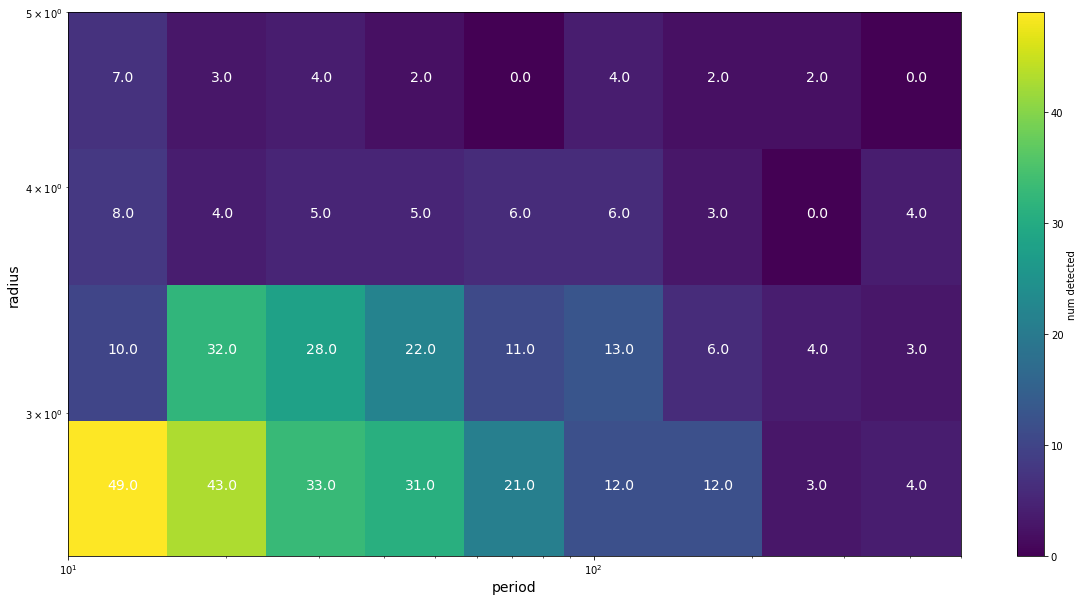

In [10]:
H, xedges, yedges = np.histogram2d(kois.koi_period, getRadii(kois), bins=(period, rp))
xcent = 0.5 * (xedges[1:] + xedges[:-1])
ycent = 0.5 * (yedges[1:] + yedges[:-1])

#X, Y = np.meshgrid(xedges, yedges)
fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
im = ax.pcolormesh(period_grid, rp_grid, H)

for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        ax.text(xcent[j],ycent[i], H.T[i,j], 
                color="white", ha="center", va="center", fontsize=14)

#plt.xlim(.1,500)
plt.xlabel('period', fontsize=14)
plt.ylabel('radius', fontsize=14)
plt.xscale('log')
plt.yscale('log')
fig.colorbar(im, label="num detected")
#plt.savefig("10hist_p10500r255.png")
plt.show()

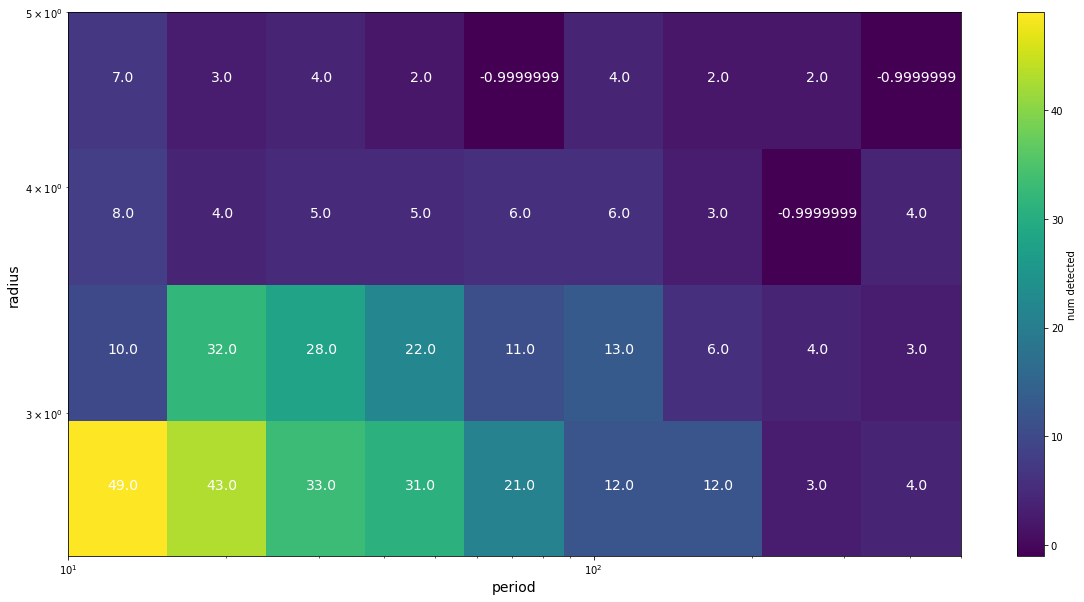

In [11]:
H[H == 0.0] = -0.9999999

fig, ax = plt.subplots(figsize=(20, 10))
#ax = fig.add_subplot(132)
im = ax.pcolormesh(period_grid, rp_grid, H)

for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        ax.text(xcent[j],ycent[i], H.T[i,j], 
                color="white", ha="center", va="center", fontsize=14)

#plt.xlim(.1,500)
plt.xlabel('period', fontsize=14)
plt.ylabel('radius', fontsize=14)
plt.xscale('log')
plt.yscale('log')
fig.colorbar(im, label="num detected")
#plt.savefig("10hist_p10500r255.png")
plt.show()

In [12]:
points = np.array(list(zip(period_grid.flatten(), rp_grid.flatten())))
values = summedCompleteness.flatten()

pc = np.array(list(zip(kois.koi_period.values, getRadii(kois).values)))

grid = griddata(points, values, pc, method='linear')
#print(grid)

In [13]:
kois['completeness'] = grid/ kiclist.size
kois['kois_rp'] = getRadii(kois)

In [14]:
occ = np.zeros((len(period)-1, len(rp)-1))


for i in range(len(period)-1):
    for j in range(len(rp)-1):
        #print(i, j)
        #print([period[i], period[i+1]], [rp[j], rp[j+1]])
        bin_ = kois[((kois.koi_period < period[i+1]) & (kois.koi_period > period[i]) & 
                     (kois.kois_rp < rp[j+1]) & (kois.kois_rp > rp[j]))]
        occ[i, j] = np.sum(bin_.totalReliability / bin_.completeness) / kiclist.size
        
print(occ)

[[0.0199626  0.00420619 0.0021519  0.00275197]
 [0.02305328 0.01689983 0.00202985 0.00166837]
 [0.024971   0.02024227 0.00209159 0.00277215]
 [0.03161079 0.02007125 0.00370456 0.00120707]
 [0.0292892  0.0140163  0.00526298 0.        ]
 [0.02384183 0.02263127 0.00861779 0.00496414]
 [0.03345532 0.01172793 0.00678752 0.00448202]
 [0.01237397 0.01344511 0.         0.00477355]
 [0.02421541 0.03302106 0.02100252 0.        ]]


In [19]:
occ.shape

(9, 4)

(9, 4)

In [22]:
c = np.zeros((len(period)-1, len(rp)-1))
c[H < 0] = 1
summedCompleteness_c = 0.5*(summedCompleteness[1:, 1:] + summedCompleteness[:-1, :-1])
occ[occ == 0.] = 1 / summedCompleteness_c[np.where(occ == 0.)]

In [64]:
occ

array([[0.0199626 , 0.00420619, 0.0021519 , 0.00275197],
       [0.02305328, 0.01689983, 0.00202985, 0.00166837],
       [0.024971  , 0.02024227, 0.00209159, 0.00277215],
       [0.03161079, 0.02007125, 0.00370456, 0.00120707],
       [0.0292892 , 0.0140163 , 0.00526298, 0.00132801],
       [0.02384183, 0.02263127, 0.00861779, 0.00496414],
       [0.03345532, 0.01172793, 0.00678752, 0.00448202],
       [0.01237397, 0.01344511, 0.00368048, 0.00477355],
       [0.02421541, 0.03302106, 0.02100252, 0.00703743]])

In [ ]:
b = kois[((kois.koi_period < 188.03015465) & (kois.koi_period > 70.71067812) & 
                     (kois.kois_rp < 5) & (kois.kois_rp > 2.5))]
np.sum(b.totalReliability / b.completeness) / kiclist.size

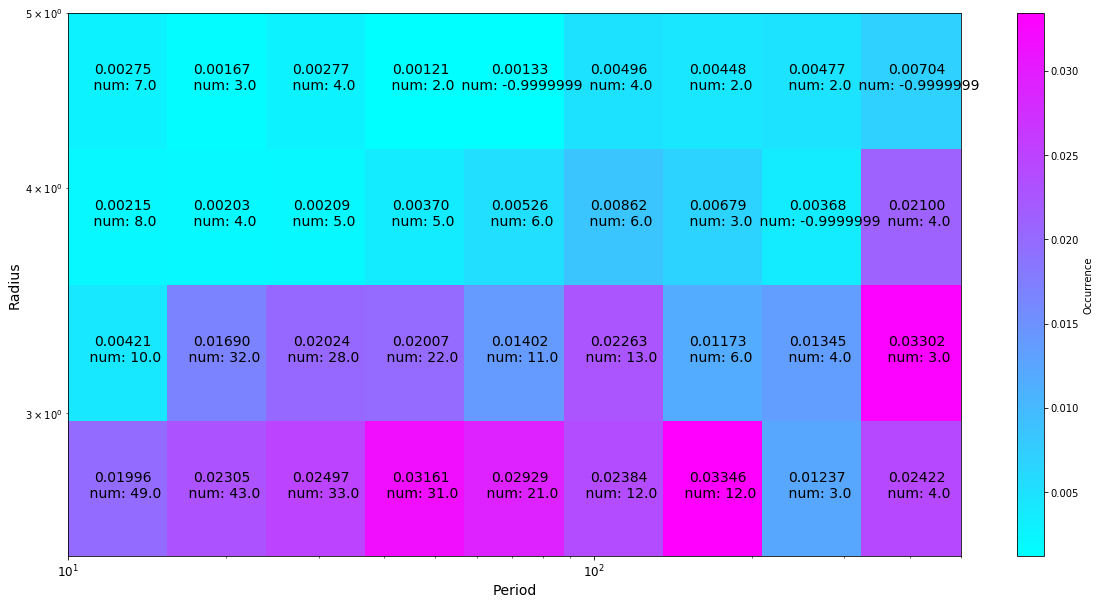

In [26]:
fig, ax = plt.subplots(figsize=(20, 10))
im = ax.pcolormesh(period_grid, rp_grid, occ, cmap='cool')
for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        t = str("%.5f" % occ.T[i,j]) + '\n num: ' + str(H.T[i,j])
        ax.text(xcent[j], ycent[i], t, 
                color="k", ha="center", va="center", fontsize=14)

ax.tick_params(axis='both', labelsize='large')
               
plt.colorbar(im, label="Occurrence")
plt.xlabel("Period", fontsize=14)
plt.ylabel("Radius", fontsize=14)
plt.xscale('log')
plt.yscale('log')
#plt.savefig('10occhist_p10500r255.png')
plt.show()

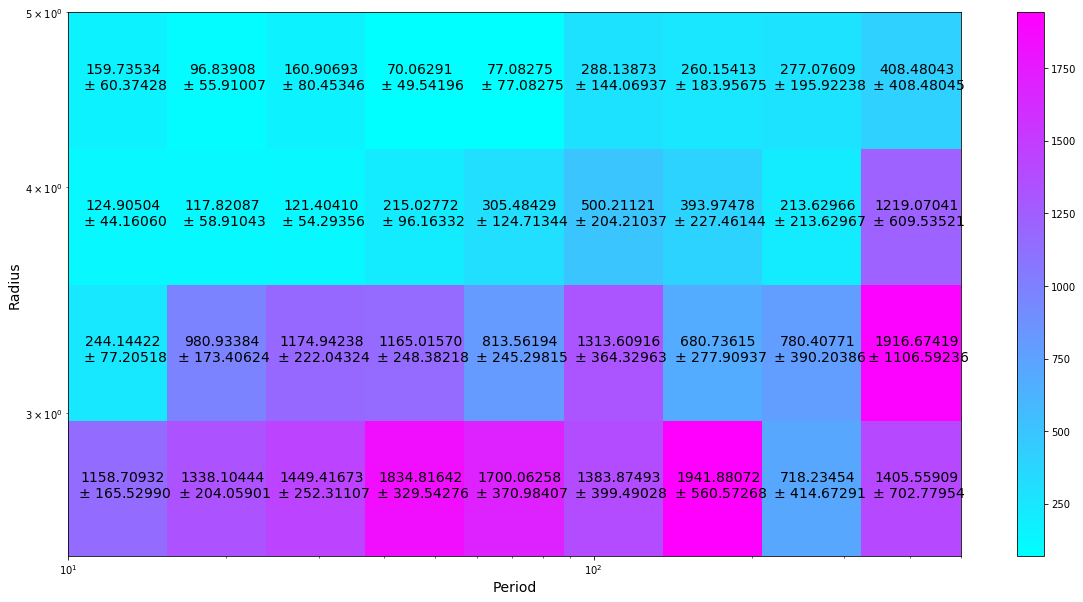

In [34]:
exp = occ * kiclist.size
exp_err = np.sqrt(np.abs(H))/np.abs(H) * exp

fig, ax = plt.subplots(figsize=(20,10))
im = ax.pcolormesh(period_grid, rp_grid, exp, cmap='cool')
for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        t = str("%.5f" % exp.T[i,j]) +'\n'+ r" $\pm$ " + str("%.5f" % exp_err.T[i,j])
        ax.text(xcent[j], ycent[i], t, 
                color="k", ha="center", va="center", fontsize=14)

plt.colorbar(im)
plt.xlabel("Period", fontsize=14)
plt.ylabel("Radius", fontsize=14)
plt.xscale('log')
plt.yscale('log')
#plt.savefig('10occhist_p10500r255.png')
plt.show()

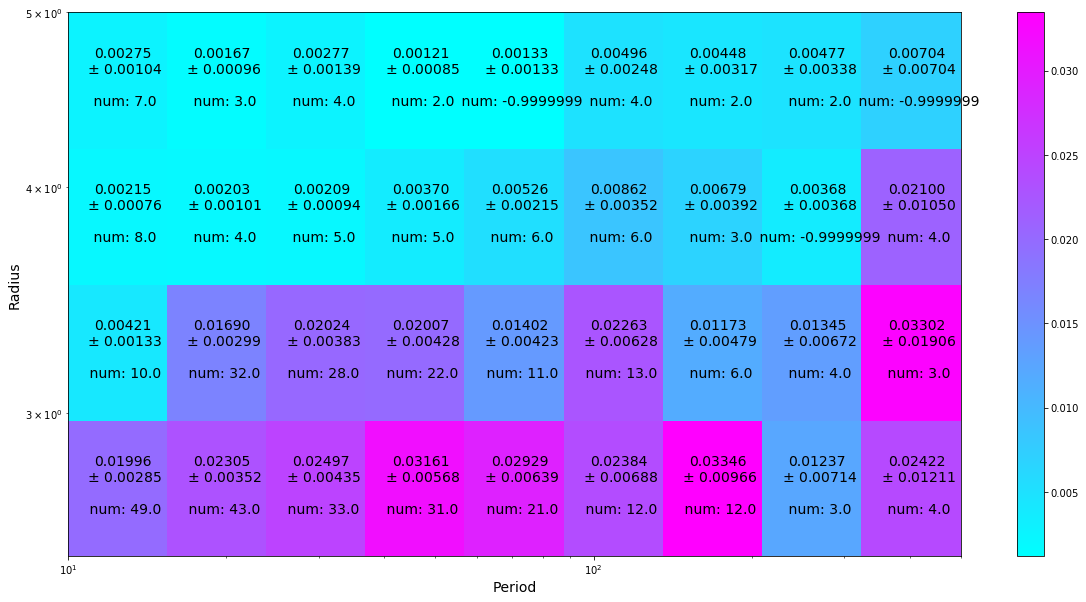

In [38]:
o = exp / kiclist.size
err = np.sqrt(np.abs(H)) * exp / (kiclist.size *np.abs(H))

fig, ax = plt.subplots(figsize=(20,10))
im = ax.pcolormesh(period_grid, rp_grid, o, cmap='cool')
for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        #err = occ.T[i,j] / np.sqrt(H.T[i,j])
        t = str("%.5f" % o.T[i,j]) + '\n' + r" $\pm$ " + str("%.5f" % err.T[i,j]) + '\n\n num: ' + str(H.T[i,j])
        ax.text(xcent[j], ycent[i], t, 
                color="k", ha="center", va="center", fontsize=14)

plt.colorbar(im)
plt.xlabel("Period", fontsize=14)
plt.ylabel("Radius", fontsize=14)
plt.xscale('log')
plt.yscale('log')
#plt.savefig('10occhist_p10500r255.png')
plt.show()

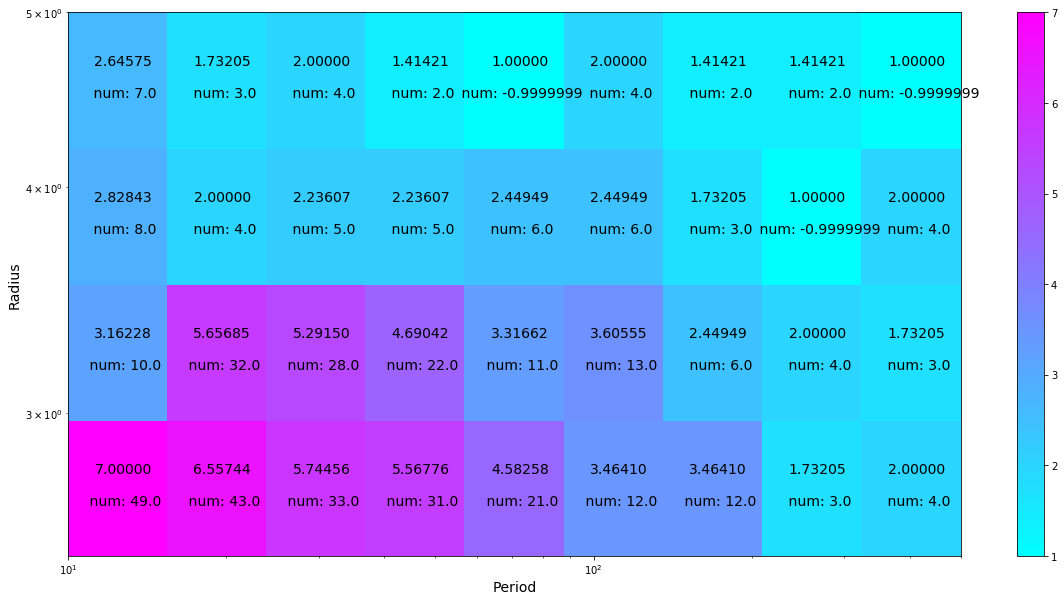

In [44]:
fig, ax = plt.subplots(figsize=(20,10))
im = ax.pcolormesh(period_grid, rp_grid, o/err, cmap='cool')
for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        #err = occ.T[i,j] / np.sqrt(H.T[i,j])
        t = str("%.5f" % (o/err).T[i,j]) +'\n\n num: ' + str(H.T[i,j])
        ax.text(xcent[j], ycent[i], t, 
                color="k", ha="center", va="center", fontsize=14)

plt.colorbar(im)
plt.xlabel("Period", fontsize=14)
plt.ylabel("Radius", fontsize=14)
plt.xscale('log')
plt.yscale('log')
#plt.savefig('10occhist_p10500r255.png')
plt.show()

In [61]:
co_period = np.empty(np.sum(c, axis=1).shape, dtype=str)
co_period[np.sum(c, axis=1) == 0] = 'k'
co_period[np.sum(c, axis=1) >= 1.] = 'r'

co_rad = np.empty(np.sum(c, axis=0).shape, dtype=str)
co_rad[np.sum(c, axis=0) == 0] = 'k'
co_rad[np.sum(c, axis=0) >= 1.] = 'r'

[0. 0. 1. 2.]


array(['k', 'k', 'r', 'r'], dtype='<U1')

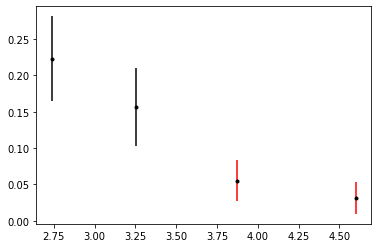

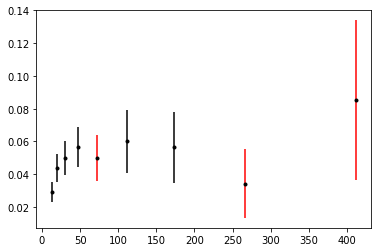

In [69]:
plt.figure()
plt.errorbar(r_cent, np.sum(occ, axis=0), yerr=np.sum(err, axis=0), fmt='k.', ecolor=co_rad)
#plt.xscale('log')

plt.figure()
plt.errorbar(p_cent, np.sum(occ, axis=1), yerr=np.sum(err, axis=1), fmt='k.', ecolor=co_period)
#plt.xscale('log')
#plt.yscale('log')

plt.show()

In [ ]:
np.sum(occ, axis=1)*100

In [ ]:
plt.hist(np.sum(H, axis=1), bins=period)

[ 2.24864320e-02  1.18228010e+00 -8.23127061e+02  2.09523167e+03]
[1.27495548 0.1024508 ]


/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in power
  del sys.path[0]
/Users/anne/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in power
  del sys.path[0]


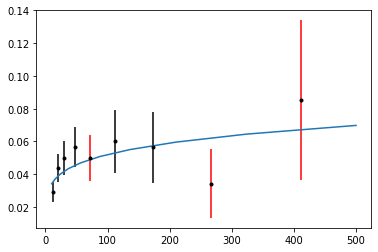

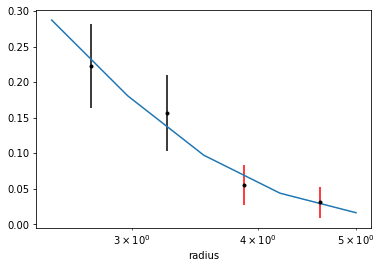

In [85]:
def power_law(x, alpha, f0):
    r = f0 * x**alpha
    return(r)

def asymp(x, a, b, c):
    r = a*x + (b/x) + c
    return(r)
def what(x, a, b):
    r = 1/(1 + b*np.exp(a*x))
    return(r)
    
def knee(x, c, beta, gamma, x0):
    r = c * x**(beta-1) * (1 - np.exp(-(x/x0)**gamma))
    return(r)

popt, pcov = curve_fit(knee, p_cent, np.sum(occ, axis=1), sigma=np.sum(err, axis=1))
print(popt)

plt.figure()
#plt.scatter(p_cent, np.sum(occ, axis=1), color='k', label="IDEM calculation X 100")
plt.errorbar(p_cent, np.sum(occ, axis=1), yerr=np.sum(err, axis=1), fmt='.k', ecolor=co_period)
plt.plot(period, knee(period, *popt))
#plt.plot(period, power_law(period, *popt))
#plt.xscale('log')
#plt.xlabel('period (days)')
#plt.yscale('log')
#plt.ylabel("planets per 100 stars per bin")
#plt.title("2.5-5Re, 1-500 days")
#plt.legend()
#plt.tight_layout()
#plt.savefig("manybins2.5_5Re_10_500d.png")

popt, pcov = curve_fit(what, r_cent, np.sum(occ, axis=0), sigma=np.sum(err, axis=0))
print(popt)

plt.figure()
#plt.scatter(r_cent, np.sum(occ, axis=0), color='k')
plt.errorbar(r_cent, np.sum(occ, axis=0), yerr=np.sum(err, axis=0), fmt='.k', ecolor=co_rad)
plt.plot(rp, what(rp, *popt))
plt.xscale('log')
plt.xlabel('radius')
plt.show()

In [ ]:
plt.figure()
plt.scatter(p_cent, np.sum(occ, axis=1), color='k', label="IDEM calculation X 100")
#plt.errorbar(p_cent, np.sum(occ, axis=1), yerr=np.sum(err, axis=1), fmt='.k')
plt.plot(period, knee(period, 1, 0.138, 2.307, 9.538), label="Petigura 2018 knee function")

In [ ]:
def powerYasympX(xdata_tuple, a, b, c, alpha):
    (x, y) = xdata_tuple
    xd = a*y + (b/y) + c
    yd = x**alpha
    r = xd*yd
    return(r.ravel())

p, r = np.meshgrid(p_cent, r_cent)
print(p.shape)
popt, pcov = curve_fit(powerYasympX, (p, r), occ.ravel())
print(popt)

d = powerYasympX((p, r), *popt)
print(d.shape)
d = d.reshape(4,4)

fig, ax = plt.subplots(figsize=(20,10))
im = ax.pcolormesh(period_grid, rp_grid, occ, cmap='cool')
CS = ax.contour(period, rp, powerYasympX((period_grid, rp_grid), *popt).reshape(5,5), 8, colors='k')
ax.clabel(CS, inline=1)

plt.colorbar(im)
plt.xscale('log')
plt.yscale('log')

fig, ax = plt.subplots(figsize=(20,10))
im = ax.pcolormesh(period_grid, rp_grid, occ-d, cmap='cool')
for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        t = str("%.5f" % (occ-d).T[i,j])
        ax.text(xcent[j]-offset[j], ycent[i], t, 
                color="k", ha="center", va="center", fontsize=14)

plt.colorbar(im)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [ ]:
ex = d * kiclist.size
offset=[2, 4, 8, 16]

fig, ax = plt.subplots(figsize=(20,10))
im = ax.pcolormesh(period_grid, rp_grid, ex, cmap='cool')
for i in range(len(yedges)-1):
    for j in range(len(xedges)-1):
        ax.text(xcent[j]-offset[j], ycent[i], int(round(ex.T[i, j])), 
                color="k", ha="center", va="center", fontsize=14)

plt.colorbar(im)
plt.xlabel("Period", fontsize=14)
plt.ylabel("Radius", fontsize=14)
plt.xscale('log')
plt.yscale('log')
#plt.savefig('10occhist_p10500r255.png')
plt.show()

In [ ]:
plt.figure()
plt.plot(p_cent, occ[:, 0])
plt.plot(p_cent, occ[:, 1])
plt.plot(p_cent, occ[:, 2])
plt.plot(p_cent, occ[:, 3])

plt.figure()
plt.plot(r_cent, occ[0, :])
plt.plot(r_cent, occ[1, :])
plt.plot(r_cent, occ[2, :])
plt.plot(r_cent, occ[3, :])
plt.show()